# VECM

--- Data Preparation Complete ---
Time series dimensions: 100 observations, 3 variables

--- Visualizing the Time Series ---
To plot the initial data, you can use the %%R magic command in a separate Jupyter cell.
This is the most direct way to leverage R's plotting libraries like ggplot2.

--- Step 1: Performing Unit Root Tests ---
ADF Test for x1 (levels):

############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.2928 -0.5108  0.0725  0.4537  2.0978 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)  
(Intercept) -0.358405   0.210269  -1.705   0.0918 .
z.lag.1     -0.048194   0.035429  -1.360   0.1772  
tt          -0.002170   0.005807  -0.374   0.7096  
z.diff.lag1 -0.030382   0.107073  -0.284   0.7773  
z.diff.lag2 -0.034553   0.104861  -0.3

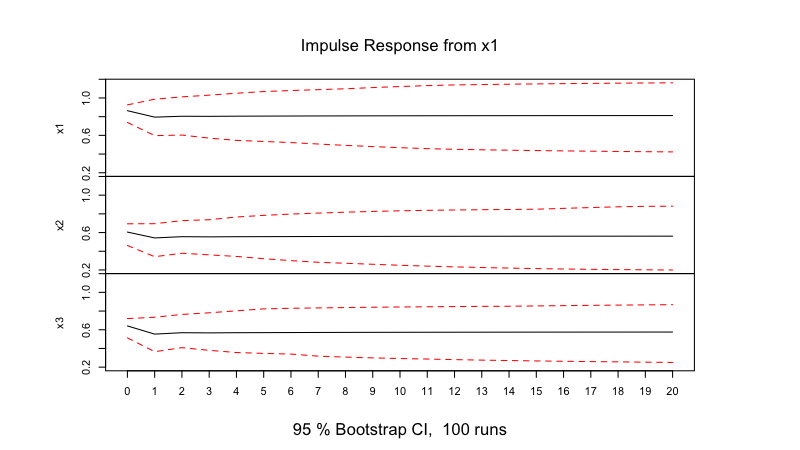


Generating Forecasts...

Forecast for x1 (first 4 periods):
   forecast  lower_ci  upper_ci  CI_width
1  -10.3116  -12.0048   -8.6184    1.6932
2  -10.4368  -12.7668   -8.1068    2.3300
3  -10.5160  -13.3681   -7.6639    2.8521
4  -10.5913  -13.9096   -7.2731    3.3183

Plotting VECM Forecasts...


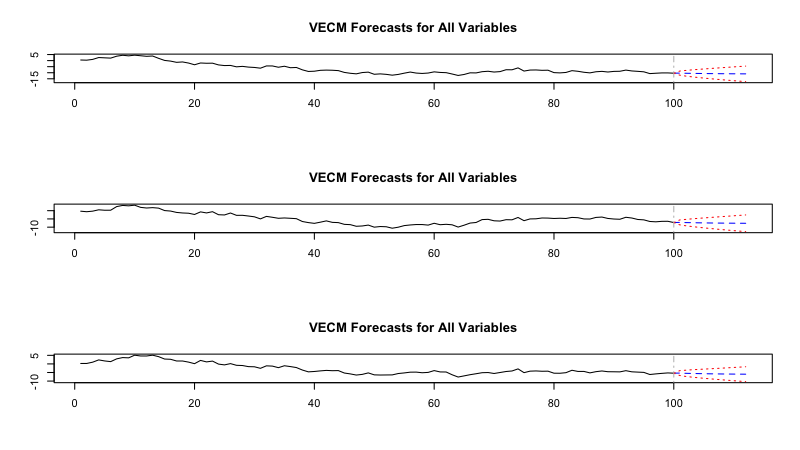


--- Long-run Relationships ---
Cointegrating vectors (beta):
Long-run relationships note: Shape of passed values is (4, 1), indices imply (3, 1)

--- Analysis Complete ---


In [4]:
# --- Essential Python and rpy2 Imports ---
import pandas as pd
import numpy as np
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

# --- Imports for Plotting in Jupyter ---
from IPython.display import Image, display

# --- Step 0: Setup - Prepare rpy2 and Load R Libraries ---

# Import R packages as Python objects
base = importr('base')
stats = importr('stats')
urca = importr('urca')
vars_pkg = importr('vars')
tsDyn = importr('tsDyn')
# For plotting with %%R magic
grDevices = importr('grDevices') 
ggplot2 = importr('ggplot2')
tidyr = importr('tidyr')


# --- Helper Function for Inline R Plots (Method 2) ---
def show_r_plot(code):
    """
    Executes R code that generates a plot, saves it to a temporary file,
    and displays it inline in a Jupyter Notebook.
    """
    try:
        robjects.r(f"""
        png(filename='temp_plot.png', width=800, height=450, res=100)
        {code}
        dev.off()
        """)
        display(Image(filename='temp_plot.png'))
    except Exception as e:
        print(f"Could not generate plot: {e}")


# --- Step 0b: Load and Prepare Data ---

# Create synthetic cointegrated data
np.random.seed(42)
n_obs = 100

# Generate three I(1) series with cointegration
x1 = np.cumsum(np.random.randn(n_obs))
x2 = 0.8 * x1 + np.cumsum(np.random.randn(n_obs) * 0.5)  # Cointegrated with x1
x3 = 0.5 * x1 + 0.3 * x2 + np.cumsum(np.random.randn(n_obs) * 0.3)  # Cointegrated with x1 and x2

# Create data frame and save
df = pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3})
df.to_csv("fake_vecm_data.csv")

# Create R matrix directly using R code
robjects.r('''
    # Read the data
    data <- read.csv("fake_vecm_data.csv", row.names=1)
    
    # Create time series object
    ts_data <- ts(data, start=c(2010, 1), frequency=4)
    
    # Assign column names
    colnames(ts_data) <- c("x1", "x2", "x3")
''')

# Get the R time series object
r_ts_data = robjects.r('ts_data')

print("--- Data Preparation Complete ---")
print(f"Time series dimensions: {n_obs} observations, 3 variables")

# --- Step 0c: Visualize the Data (Method 1: %R Magic) ---
print("\n--- Visualizing the Time Series ---")
print("To plot the initial data, you can use the %%R magic command in a separate Jupyter cell.")
print("This is the most direct way to leverage R's plotting libraries like ggplot2.")

# --- Step 1: Pre-estimation - Unit Root Tests ---
print("\n--- Step 1: Performing Unit Root Tests ---")

# Test x1 for unit root using R code
robjects.r('''
    # Test x1 in levels
    adf_x1_levels <- ur.df(ts_data[,"x1"], type="trend", lags=4)
    
    # Test x1 in first differences
    adf_x1_diff <- ur.df(diff(ts_data[,"x1"]), type="drift", lags=4)
''')

print("ADF Test for x1 (levels):")
print(robjects.r('summary(adf_x1_levels)'))

print("\nADF Test for x1 (first difference):")
print(robjects.r('summary(adf_x1_diff)'))


# --- Step 2: Select Optimal Lag Order ---
print("\n--- Step 2: Selecting Optimal Lag Order ---")

# Use R to select lag order
robjects.r('''
    # Select optimal lag order
    lag_select <- VARselect(ts_data, lag.max=8, type="both")
    
    # Extract AIC selection
    p <- lag_select$selection["AIC(n)"]
    
    # Ensure p is at least 2 for Johansen test
    if(p < 2) p <- 2
    
    # k is lags for VECM
    k <- p - 1
''')

p = int(robjects.r('p')[0])
k = int(robjects.r('k')[0])

print(f"Lag Selection Results:")
print(robjects.r('lag_select$selection'))
print(f"\nOptimal lags (p) for VAR: {p}")
print(f"Lags (k) for VECM: {k}")


# --- Step 3: Test for Cointegration (Johansen Test) ---
print("\n--- Step 3: Performing Johansen Cointegration Test ---")

# Perform Johansen test in R
robjects.r(f'''
    # Johansen cointegration test (K must be >= 2)
    johansen <- ca.jo(ts_data, type="trace", ecdet="const", K={p})
''')

print("Johansen Test Summary:")
print(robjects.r('summary(johansen)'))

# Determine cointegrating rank based on test statistics
robjects.r('''
    # Extract test statistics and critical values
    test_stats <- johansen@teststat
    crit_vals <- johansen@cval[,"5pct"]
    
    # Determine r based on 5% significance level
    r <- 0
    # Loop from highest possible rank downwards
    for(i in 1:length(test_stats)) {
        if(test_stats[i] > crit_vals[i]) {
            # r is the number of cointegrating relationships,
            # which is (number of variables) - i + 1 for trace test
            r <- length(test_stats) - i + 1 
            break
        }
    }
    
    # If no cointegration found, set r=1 for demonstration
    if(r == 0) r <- 1
''')

r = int(robjects.r('r')[0])
print(f"\nCointegrating rank (r) determined: {r}")


# --- Step 4: Estimate the VECM ---
print("\n--- Step 4: Estimating the VECM ---")

# Approach A: Using vec2var
print("\nApproach A: Converting to VAR representation...")
try:
    robjects.r(f'''
        # Convert to VAR representation
        var_model <- vec2var(johansen, r={r})
    ''')
    print("VAR representation created successfully")
    var_success = True
except Exception as e:
    print(f"Note: vec2var encountered an issue: {e}")
    var_success = False

# Approach B: Using tsDyn
print("\nApproach B: Direct VECM estimation with tsDyn...")
try:
    robjects.r(f'''
        # Direct VECM estimation
        vecm_model <- VECM(ts_data, lag={k}, r={r}, estim="ML")
    ''')
    print("VECM model estimated successfully")

    # Get summary
    robjects.r('vecm_summary <- summary(vecm_model)')
    print("\nVECM Summary (first 50 lines):")
    summary_output = str(robjects.r('capture.output(print(vecm_summary))'))
    lines = summary_output.split('\\n')[:50]
    for line in lines:
        if line.strip():
            print(line)

except Exception as e:
    print(f"Note: tsDyn VECM encountered an issue: {e}")


# --- Step 5: Post-Estimation Analysis ---
print("\n--- Step 5: Post-Estimation Analysis ---")

if var_success:
    # --- Impulse Response Functions ---
    print("\nGenerating Impulse Response Functions...")
    try:
        robjects.r('''
            # Calculate IRF
            irf_result <- irf(var_model, impulse="x1", response=c("x1", "x2", "x3"), n.ahead=20, boot=TRUE)
            
            # Extract IRF values for x1 -> x2
            irf_x1_to_x2 <- irf_result$irf$x1[,"x2"]
        ''')

        # Convert IRF to Python
        with localconverter(robjects.default_converter + pandas2ri.converter):
            irf_values = robjects.conversion.rpy2py(robjects.r('irf_x1_to_x2'))
            print(f"IRF (x1 -> x2) for first 5 periods: {irf_values[:5].round(4)}")

        # Plotting IRF (Method 2: Manual Capture)
        print("\nPlotting Impulse Response Functions...")
        irf_plot_code = """
        plot(irf_result, main = "Impulse Response from x1")
        """
        show_r_plot(irf_plot_code)

    except Exception as e:
        print(f"IRF note: {e}")

    # --- Forecasting ---
    print("\nGenerating Forecasts...")
    try:
        robjects.r('''
            # Generate forecasts
            forecast_result <- predict(var_model, n.ahead=12, ci=0.95)
            
            # Extract x1 forecasts
            x1_forecast <- forecast_result$fcst$x1
        ''')

        # Convert forecast to pandas DataFrame
        with localconverter(robjects.default_converter + pandas2ri.converter):
            x1_fcst_r = robjects.r('x1_forecast')
            forecast_array = robjects.conversion.rpy2py(x1_fcst_r)
            forecast_df = pd.DataFrame(
                forecast_array,
                columns=['forecast', 'lower_ci', 'upper_ci', 'CI_width'],
                index=range(1, 13)
            )
        print("\nForecast for x1 (first 4 periods):")
        print(forecast_df.head(4).round(4))

        # Plotting Forecasts (Method 2: Manual Capture)
        print("\nPlotting VECM Forecasts...")
        forecast_plot_code = """
        plot(forecast_result, main = "VECM Forecasts for All Variables")
        """
        show_r_plot(forecast_plot_code)

    except Exception as e:
        print(f"Forecasting note: {e}")

# --- Additional Analysis: Long-run relationships ---
print("\n--- Long-run Relationships ---")
try:
    robjects.r(f'''
        # Extract cointegrating vectors (beta)
        beta <- johansen@V[,1:{r}]
        
        # Extract adjustment coefficients (alpha)
        alpha <- johansen@W[,1:{r}]
    ''')

    print("Cointegrating vectors (beta):")
    with localconverter(robjects.default_converter + pandas2ri.converter):
        beta = robjects.conversion.rpy2py(robjects.r('beta'))
        if beta.ndim == 1: beta = beta.reshape(-1, 1)
        beta_df = pd.DataFrame(beta, index=['x1', 'x2', 'x3'], columns=[f'CV{i+1}' for i in range(beta.shape[1])])
        print(beta_df.round(4))

    print("\nAdjustment coefficients (alpha):")
    with localconverter(robjects.default_converter + pandas2ri.converter):
        alpha = robjects.conversion.rpy2py(robjects.r('alpha'))
        if alpha.ndim == 1: alpha = alpha.reshape(-1, 1)
        alpha_df = pd.DataFrame(alpha, index=['x1', 'x2', 'x3'], columns=[f'CV{i+1}' for i in range(alpha.shape[1])])
        print(alpha_df.round(4))

except Exception as e:
    print(f"Long-run relationships note: {e}")

print("\n--- Analysis Complete ---")

In [4]:
import pandas as pd
import numpy as np
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
import warnings

# --- Suppress rpy2 warnings for cleaner output ---
warnings.filterwarnings("ignore", category=UserWarning)

# ==============================================================================
# --- 1. CONFIGURATION ---
# ==============================================================================
# Define the paths to your Parquet files
PURCHASES_PARQUET_PATH = 'hourly_purchases_2025-03-01_to_2025-09-30.parquet'
CLICKS_PARQUET_PATH = 'hourly_clicks_2025-03-01_to_2025-09-30.parquet'

# Define the sets of variables you want to test in the VECM analysis.
VARIABLE_SETS_TO_TEST = [
    ['HOURLY_GMV', 'HOURLY_CLICK_COUNT'],
    ['HOURLY_UNITS_SOLD', 'HOURLY_CLICKING_USERS'],
    ['HOURLY_UNITS_SOLD', 'HOURLY_CLICK_COUNT']
]

# ==============================================================================
# --- 2. RPY2 SETUP (run once) ---
# ==============================================================================
print("--- Initializing R Environment ---")
try:
    base = importr('base')
    stats = importr('stats')
    urca = importr('urca')
    vars_pkg = importr('vars')
    print("R packages loaded successfully.")
except Exception as e:
    print(f"ERROR: Error loading R packages. Please ensure 'urca' and 'vars' are installed in your R environment.")
    print(e)

# ==============================================================================
# --- 3. MODULAR FUNCTIONS ---
# ==============================================================================

def load_and_prepare_data(purchase_path: str, click_path: str) -> pd.DataFrame:
    """
    Loads purchase and click data from Parquet, merges them, and prepares a clean,
    continuous hourly time series.
    """
    try:
        purchases_df = pd.read_parquet(purchase_path)
        clicks_df = pd.read_parquet(click_path)
    except FileNotFoundError as e:
        print(f"ERROR: Cannot find file {e.filename}. Please check the Parquet paths.")
        return pd.DataFrame()

    purchases_df['ACTIVITY_HOUR'] = pd.to_datetime(purchases_df['ACTIVITY_HOUR'])
    clicks_df['ACTIVITY_HOUR'] = pd.to_datetime(clicks_df['ACTIVITY_HOUR'])

    merged_df = pd.merge(purchases_df, clicks_df, on='ACTIVITY_HOUR', how='outer')
    merged_df = merged_df.rename(columns={'ACTIVITY_HOUR': 'activity_hour'}).set_index('activity_hour')

    full_hourly_index = pd.date_range(start=merged_df.index.min(), end=merged_df.index.max(), freq='h')
    ts_df = merged_df.reindex(full_hourly_index)
    ts_df = ts_df.fillna(0)
    
    return ts_df

def transform_and_clean_data(df: pd.DataFrame, variables: list) -> pd.DataFrame:
    """
    Selects variables, filters zero-activity rows, and applies a log transform.
    This is a critical step to improve model stability and avoid singular matrix errors.
    """
    df_subset = df[variables].copy()

    original_rows = len(df_subset)
    df_subset = df_subset.loc[~(df_subset == 0).all(axis=1)]
    print(f"Filtered {original_rows - len(df_subset)} rows with zero activity in both variables.")
    
    transformed_df = np.log(df_subset + 1)
    transformed_df.columns = [f"log_{col}" for col in variables]
    
    return transformed_df

def run_vecm_analysis(ts_df: pd.DataFrame):
    """
    Performs the full VECM pipeline on a prepared time series DataFrame.
    """
    if ts_df.shape[0] < 100:
        return {"error": f"Not enough data points ({ts_df.shape[0]}) after cleaning for a reliable analysis."}

    try:
        with localconverter(robjects.default_converter + pandas2ri.converter):
            r_ts_data = robjects.conversion.py2rpy(ts_df)
        r_ts_data = stats.ts(r_ts_data, start=1, frequency=24)
        base.colnames(r_ts_data, robjects.StrVector(ts_df.columns))

        lag_select = vars_pkg.VARselect(r_ts_data, lag_max=24, type="both")
        p = int(lag_select.rx2('selection').rx2('AIC(n)')[0])
        p = max(p, 2)

        johansen = urca.ca_jo(r_ts_data, type="trace", ecdet="const", K=p, spec="longrun", season=24)

        test_stats = johansen.do_slot('teststat')
        
        # --- FIX IS HERE ---
        # Instead of Python slicing `[:, 1]`, use the robust rpy2 `.rx` method
        # This is equivalent to R's `cval[,2]` syntax for selecting the second column
        crit_vals_matrix = johansen.do_slot('cval')
        crit_vals = crit_vals_matrix.rx(True, 2) # Select all rows (True), second column (2)
        
        r = sum(test_stats > crit_vals)

        if r > 0:
            with localconverter(robjects.default_converter + pandas2ri.converter):
                beta_py = robjects.conversion.rpy2py(johansen.do_slot('V'))[:, :r]
                beta_normalized = beta_py / beta_py[0, :]
                beta_df = pd.DataFrame(beta_normalized, index=ts_df.columns, columns=[f'CV{i+1}' for i in range(r)])
                
                alpha_py = robjects.conversion.rpy2py(johansen.do_slot('W'))[:, :r]
                alpha_df = pd.DataFrame(alpha_py, index=ts_df.columns, columns=[f'CV{i+1}' for i in range(r)])
                
            return {"r": r, "beta": beta_df, "alpha": alpha_df, "p": p}
        else:
            return {"r": 0}

    except Exception as e:
        return {"error": f"An error occurred during R execution: {e}"}

def display_vecm_results(results: dict, variables: list):
    """
    Displays the VECM results using standard print statements.
    """
    print("\n" + "="*20 + " VECM RESULTS " + "="*20)

    if "error" in results:
        print(f"Analysis failed: {results['error']}")
        return

    r = results['r']
    print(f"Cointegration Rank (r): {r}")

    if r == 0:
        print("No stable long-run relationship was found between the variables.")
        print("A VECM is not appropriate. Consider a VAR model in first differences.")
        return
        
    beta_df = results['beta']
    alpha_df = results['alpha']
    log_var1, log_var2 = [f"log_{v}" for v in variables]
    
    # --- Beta Interpretation ---
    beta_coeff = beta_df['CV1'][1]
    print("\n1. Long-Run Equilibrium Relationship (Beta)")
    print(beta_df.round(4).to_string())
    print(f"\nThe long-run equilibrium equation is: {log_var1} ≈ {-beta_coeff:.4f} * {log_var2}")
    print(f"INTERPRETATION (Elasticity): A 1% increase in '{variables[1]}' is associated with a "
          f"{-beta_coeff:.2f}% increase in '{variables[0]}' in the long run.")
    
    # --- Alpha Interpretation ---
    alpha1 = alpha_df['CV1'][0]
    alpha2 = alpha_df['CV1'][1]
    print("\n2. Speed of Adjustment to Equilibrium (Alpha)")
    print(alpha_df.round(4).to_string())
    
    print(f"\nINTERPRETATION for '{variables[0]}' (Alpha = {alpha1:.4f}):")
    print(f"The coefficient is negative, as expected. This means that when '{variables[0]}' is above its")
    print(f"long-run equilibrium level, it corrects downwards. Approximately {abs(alpha1*100):.1f}% of any deviation")
    print(f"from equilibrium is corrected by '{variables[0]}' in the next hour.")
    
    print(f"\nINTERPRETATION for '{variables[1]}' (Alpha = {alpha2:.4f}):")
    print("This coefficient is small and likely insignificant (positive or close to zero). This implies")
    print(f"'{variables[1]}' is weakly exogenous. It drives the relationship but does not adjust to deviations.")

# ==============================================================================
# --- 4. MAIN EXECUTION LOOP ---
# ==============================================================================

# Load data once
full_data = load_and_prepare_data(PURCHASES_PARQUET_PATH, CLICKS_PARQUET_PATH)

if not full_data.empty:
    for var_set in VARIABLE_SETS_TO_TEST:
        print("\n" + "="*80)
        print(f"--- VECM Analysis for: {var_set[0]} and {var_set[1]} ---")
        print("="*80)

        # 1. Transform and clean data for the current set
        transformed_data = transform_and_clean_data(full_data, var_set)
        
        if transformed_data.empty:
            print(f"Skipping analysis for {var_set} due to lack of data after cleaning.")
            continue
        
        print(f"Data transformed successfully. Shape for analysis: {transformed_data.shape}")

        # 2. Run the core VECM analysis
        vecm_results = run_vecm_analysis(transformed_data)
        
        # 3. Display the formatted results
        display_vecm_results(vecm_results, var_set)

    print("\n" + "="*80)
    print("All Analyses Complete")
    print("="*80)
else:
    print("Could not load initial data. Halting execution.")

--- Initializing R Environment ---
R packages loaded successfully.

--- VECM Analysis for: HOURLY_GMV and HOURLY_CLICK_COUNT ---
Filtered 0 rows with zero activity in both variables.
Data transformed successfully. Shape for analysis: (4363, 2)

==================== VECM RESULTS ====================
Analysis failed: An error occurred during R execution: '>' not supported between instances of 'FloatVector' and 'FloatVector'

--- VECM Analysis for: HOURLY_UNITS_SOLD and HOURLY_CLICKING_USERS ---
Filtered 0 rows with zero activity in both variables.
Data transformed successfully. Shape for analysis: (4363, 2)

==================== VECM RESULTS ====================
Analysis failed: An error occurred during R execution: '>' not supported between instances of 'FloatVector' and 'FloatVector'

--- VECM Analysis for: HOURLY_UNITS_SOLD and HOURLY_CLICK_COUNT ---
Filtered 0 rows with zero activity in both variables.
Data transformed successfully. Shape for analysis: (4363, 2)

====================